In [1]:
import numpy as np
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

NVIDIA GeForce RTX 2080 Ti
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Number of devices: 1


### Pick-a-dataset

In [3]:
# CIFAR 10
training_dataset = torchvision.datasets.CIFAR10(root='datasets',download=True, train=True)
testing_dataset = torchvision.datasets.CIFAR10(root='datasets',download=True, train=False)
x_train = torch.Tensor(training_dataset.data).permute(0, 3, 1, 2)
y_train = torch.Tensor(training_dataset.targets).to(torch.long)
x_test = torch.Tensor(testing_dataset.data).permute(0, 3, 1 ,2)
y_test = torch.Tensor(testing_dataset.targets).to(torch.long)
print(x_train.shape)
print(x_test.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])


In [4]:
batch_size = 250
xy_train = torch.utils.data.DataLoader(list(zip(x_train,
                                                y_train)),
                                       shuffle=True, batch_size=batch_size,
                                       num_workers=4)
xy_val = torch.utils.data.DataLoader(list(zip(x_test, y_test)),
                                     shuffle=False, batch_size=batch_size,
                                     num_workers=4)

/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Important shapes for the model...

In [29]:
x_train.shape[1:] # See below...

(4,)

In [30]:
len(np.unique(y_train)) # See below...

3

In [5]:
class ImageEncoder(torch.nn.Module):
    def __init__(self,
                 latent_size = 32,
                 **kwargs):
        super().__init__(**kwargs)
        self.conv1 = torch.nn.Conv2d(3, # Input channels
                                     latent_size, # Output channels
                                     kernel_size=(6,6), # Kernel window
                                     stride=(1,1), # Step size
                                     padding=(0,0))
        self.conv2 = torch.nn.Conv2d(latent_size, # Input channels
                                     latent_size, # Output channels
                                     kernel_size=(6,6), # Kernel window
                                     stride=(1,1), # Step size
                                     padding=(0,0))
        self.conv3 = torch.nn.Conv2d(latent_size, # Input channels
                                     latent_size, # Output channels
                                     kernel_size=(4,4), # Kernel window
                                     stride=(1,1), # Step size
                                     padding=(0,0))
        self.conv4 = torch.nn.Conv2d(latent_size, # Input channels
                                     latent_size, # Output channels
                                     kernel_size=(3,3), # Kernel window
                                     stride=(1,1), # Step size
                                     padding=(0,0))
        self.conv_activation = torch.nn.GELU()
        
        self.pool1_2 = torch.nn.MaxPool2d((2,2))
        self.pool3_4 = torch.nn.MaxPool2d((2,2))
        
        self.flatten = torch.nn.Flatten()
        self.latent_layer = torch.nn.Linear(latent_size*3*3,latent_size)
        self.layer_norm = torch.nn.LayerNorm(latent_size)
    def forward(self, x):
        y = x
        y = self.conv1(y)
        y = self.conv_activation(y)
        y = self.conv2(y)
        y = self.conv_activation(y)
        y = self.pool1_2(y)
        y = self.conv3(y)
        y = self.conv_activation(y)
        y = self.conv4(y)
        y = self.conv_activation(y)
        y = self.pool3_4(y)
        y = self.flatten(y)
        y = self.latent_layer(y)
        y = self.layer_norm(y)
        return y

In [6]:
class ContrastiveNetwork(pl.LightningModule):
    def __init__(self,
                 latent_size = 64,
                 **kwargs):
        super().__init__(**kwargs)

        self.normalize = torchvision.transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225]),
        ])
        self.transform = torchvision.transforms.Compose([
            # torchvision.transforms.RandomAffine(degrees=(-10.0,10.0),
            #                                     translate=(0.1,0.1),
            #                                     scale=(0.9,1.1),
            #                                     shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
            torchvision.transforms.RandomResizedCrop(32,antialias=True),
            torchvision.transforms.ColorJitter(brightness=0.5,hue=0.3,contrast=0.3)
        ])
        self.encoder = ImageEncoder(latent_size=latent_size)
        
        # self.output_layer = DenseLayer(,embedding_size)
        self.mca = torchmetrics.classification.MulticlassAccuracy(num_classes=10)
        self.cce = torch.nn.CrossEntropyLoss().to(device)
        
    def forward(self, x):
        y = x
        y = y1 = y2 = self.normalize(y)
        if self.training:
            y1 = self.transform(y1)
            y2 = self.transform(y2)
        y1 = self.encoder(y1)
        y2 = self.encoder(y2)
        y = y1 @ y2.t()
        return y, y1, y2

    def predict(self, x1, x2):
        y1 = self.normalize(x1)
        y2 = self.normalize(x2)
        if self.training:
            y1 = self.transform(y1)
            y2 = self.transform(y2)
        y1 = self.encoder(y1)
        y2 = self.encoder(y2)
        y = y1 @ y2.t()
        return y, y1, y2
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_pred, _, _ = self(x)
        y_true = torch.arange(len(y_pred),requires_grad=False).to(device)
        loss1 = self.cce(y_pred, y_true)
        loss2 = self.cce(y_pred.t(), y_true)
        loss = (loss1+loss2)/2.0
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        acc1 = self.mca(y[torch.argmax(y_pred,-1)], y)
        acc2 = self.mca(y[torch.argmax(y_pred.t(),-1)], y)
        acc = (acc1+acc2)/2.0
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred, _, _ = self(x)
        y_true = torch.arange(len(y_pred),requires_grad=False).to(device)
        loss1 = self.cce(y_pred, y_true)
        loss2 = self.cce(y_pred.t(), y_true)
        loss = (loss1+loss2)/2.0
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        acc1 = self.mca(y[torch.argmax(y_pred,-1)], y)
        acc2 = self.mca(y[torch.argmax(y_pred.t(),-1)], y)
        acc = (acc1+acc2)/2.0
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        return loss

In [12]:
model = ContrastiveNetwork(latent_size=256)
print(model)

ContrastiveNetwork(
  (encoder): ImageEncoder(
    (conv1): Conv2d(3, 256, kernel_size=(6, 6), stride=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(6, 6), stride=(1, 1))
    (conv3): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1))
    (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (conv_activation): GELU(approximate='none')
    (pool1_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (pool3_4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (latent_layer): Linear(in_features=2304, out_features=256, bias=True)
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (mca): MulticlassAccuracy()
  (cce): CrossEntropyLoss()
)


In [15]:
y, y1, y2 = model(x_train[0:batch_size])
print(y.shape)
print(y1[0:1])
print(y2[0:1])

torch.Size([250, 250])
tensor([[-7.6604e-02, -1.5567e+00,  3.8154e-01,  1.2578e+00,  8.5901e-01,
          1.7055e-01,  4.6711e-01, -1.4170e+00, -5.7133e-01,  1.3169e+00,
         -2.1538e-01, -8.2456e-01,  2.7733e-01, -6.9704e-02, -4.3509e-01,
         -8.1871e-01,  1.0877e+00,  1.3495e+00,  1.5177e-02, -3.9557e-01,
         -1.5409e+00,  1.7998e+00, -7.8613e-01,  1.1164e+00, -6.8735e-01,
         -1.7071e+00, -1.2296e+00, -3.7261e-01,  9.2846e-01, -2.9588e-01,
         -3.0033e-01, -1.6686e+00,  3.8189e-03, -9.1313e-01, -1.1754e+00,
         -1.9048e-01,  1.2614e+00,  2.6614e+00, -1.0616e-01,  4.8278e-01,
         -3.9702e-01, -1.5455e+00,  8.0801e-01, -8.4299e-01, -1.0582e+00,
          2.9152e-01,  7.4443e-01,  3.3372e-01,  1.3439e+00, -7.0153e-01,
         -8.7927e-01,  2.0684e+00,  8.1491e-01,  1.0579e+00,  1.0958e+00,
          7.9441e-01,  8.0829e-01,  1.1621e+00,  1.4612e+00,  5.7618e-01,
         -8.9424e-01, -1.5944e+00,  4.4173e-01,  4.0124e-01, -1.2137e+00,
          7.323

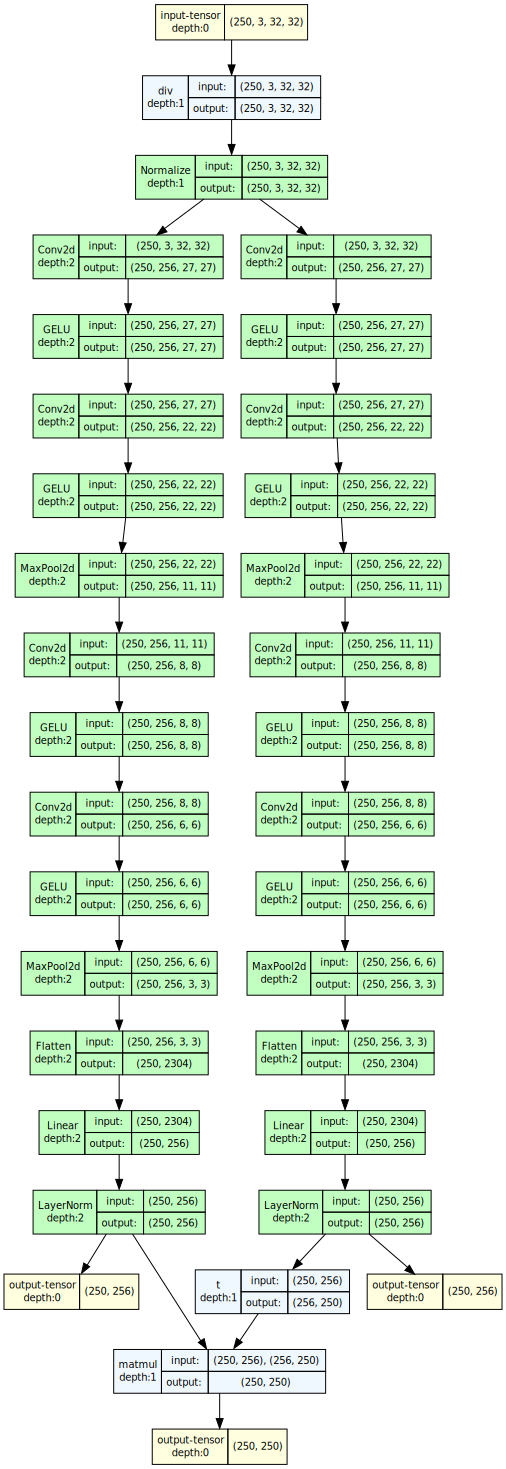

In [16]:
model_graph = draw_graph(model,
                         input_size=x_train[0:batch_size].shape,
                         device=device,hide_inner_tensors=True,
                         hide_module_functions=True,expand_nested=False,
                         depth=2)
model_graph.visual_graph

### Pretraining Accuracy

In [17]:
logger = pl.loggers.CSVLogger("lightning_logs",
                              name="CIIP-Attempt3",
                              version="demo-0") # Change later to avoid overwriting
trainer = pl.Trainer(logger=logger,
                     max_epochs=300,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.validate(model,xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory lightning_logs/CIIP-Attempt3/demo-0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │            1.0            │
│         val_loss          │   0.002906620502471924    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.002906620502471924, 'val_acc': 1.0}]

In [13]:
# Before Training
acc = []
for i in range(0,100,batch_size):
    y, _, _ = model.predict(x_test[i:i+batch_size],x_train[0:100]) 
    acc += [model.mca(y_train[0:100][torch.argmax(y,-1)],y_test[i:i+batch_size]).numpy()]
np.mean(acc)

0.11903001

### Training the Model

In [26]:
trainer.fit(model, xy_train, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory lightning_logs/CIIP-Attempt3/demo-0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | ImageEncoder       | 4.6 M 
1 | mca     | MulticlassAccuracy | 0     
2 | cce     | CrossEntropyLoss   | 0     
-----------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.468    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


### Load the model checkpoint under a different version path to avoid overwriting the checkpoint file

In [14]:
logger = pl.loggers.CSVLogger("lightning_logs",
                              name="CIIP-Attempt3",
                              version="restart-0")
trainer = pl.Trainer(logger=logger,
                     max_epochs=300,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])
trainer.fit(model, xy_train, xy_val,
            ckpt_path="lightning_logs/CIIP-Attempt3/demo-0/checkpoints/epoch=299-step=60000.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory lightning_logs/CIIP-Attempt3/restart-0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
Restoring states from the checkpoint path at lightning_logs/CIIP-Attempt3/demo-0/checkpoints/epoch=299-step=60000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | ImageEncoder       | 4.6 M 
1 | mca     | MulticlassAccuracy | 0     
2 | cce     | CrossEntropyLoss   | 0     
-----------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.468    Total estimated model params size (MB)
Restore

Sanity Checking: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [16]:
acc = []
for i in range(0,100,batch_size):
    y, _, _ = model.predict(x_test[i:i+batch_size],x_train[0:100]) 
    acc += [model.mca(y_train[0:100][torch.argmax(y,-1)],y_test[i:i+batch_size]).numpy()]
np.mean(acc)

0.20360722

Note: The result above will just be *improved* compared to the previous evaluation made prior to training, but the reference targets are just the *first* patterns of those three classes in the training data set. These are not necessarily the best reference points to use for identifying class membership for the data, so additional work should be done to validate model performance. Nevertheless, the improvement observed above and the loss metric improvement indicates that the contrastive approach is working.